Импорт

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns

In [105]:
import matplotlib.pyplot as plt
from tifffile import imread
from wordcloud import WordCloud

In [106]:
import keras

In [107]:
import os

The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

In [108]:
#from keras.layers import CuDNNLSTM


In [109]:
#from keras.layers import CuDNN

In [110]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, LSTM, Embedding, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [111]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [112]:
from keras.optimizers.legacy import Adam

Дата

In [113]:
df_train = pd.read_csv('./new_data/train_accident_normalized_text.csv')
df_test = pd.read_csv('./new_data/test_accident_normalized_text.csv')
df_combine = pd.read_csv('./new_data/combine_accident_normalized_text.csv')

График

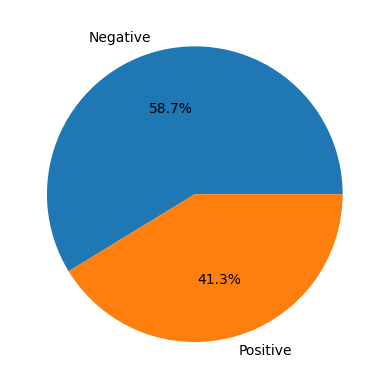

1.422873618452667


In [114]:
label_count = df_train['target'].value_counts()
labels = ['Negative', 'Positive']

plt.pie(label_count, labels=labels, autopct='%1.1f%%')

plt.show()

print(label_count[0] / label_count[1])

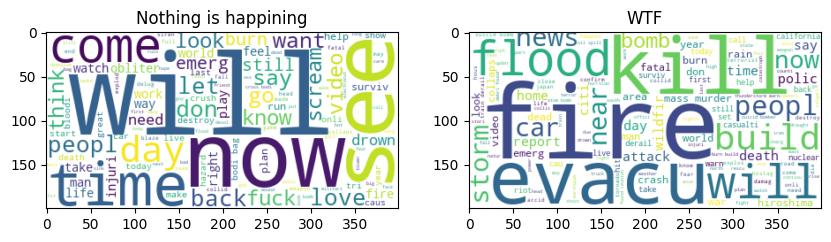

In [115]:
negative_cases = "".join(df_combine[df_combine['target'] == 0]['text_normalized'].values)
positive_cases = "".join(df_combine[df_combine['target'] == 1]['text_normalized'].values)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Nothing is happining')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('WTF')

plt.show()

Атомизированные предложения тренировочной и тестовой выборки

In [116]:
sentences_train = df_train['text_normalized'].values
sentences_test = df_test['text_normalized'].values

In [117]:
#
print(np.mean([len(text) for text in df_train['text_normalized']]))
#
print(df_train['text_normalized'][0])
#
print(len(df_train['text_normalized'][0]))

49.29155097183657
drunk meal cook total obliter
29


In [118]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(sentences_train)

sequences_train = tokenizer.texts_to_sequences(sentences_train)

# This is used for Embedding layer afterwards
num_words = len(tokenizer.word_index)

print(num_words)

maxlen_tokens = 20

# The reason that the maxlength is different than the true max length is that the texts are tokenized
padded_sequences_train = pad_sequences(sequences_train, maxlen=maxlen_tokens, padding='post', truncating='post')

padded_sequences_train[0]

8886


array([1215, 3842,  967,  286,   73,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [119]:
num_validation_samples = round(0.2 * len(padded_sequences_train))

seq_train = padded_sequences_train[num_validation_samples:]
labels_train = df_train['target'].values[num_validation_samples:]
seq_validate = padded_sequences_train[:num_validation_samples]
labels_validate = df_train['target'].values[:num_validation_samples]

print(len(seq_train))
print(len(seq_validate))

print(seq_train[0])
print(seq_train.shape)

4034
1008
[1004   13  412   29  195 1089   12   40  413  460  390    0    0    0
    0    0    0    0    0    0]
(4034, 20)


1

In [120]:
model = Sequential()

model.add(Embedding(input_dim=(num_words+1), output_dim=32, input_length=maxlen_tokens))

model.add(LSTM(128, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(units=256, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))

model.build(input_shape=(None, maxlen_tokens))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 20, 32)            284384    
                                                                 
 lstm_18 (LSTM)              (None, 20, 128)           82432     
                                                                 
 lstm_19 (LSTM)              (None, 128)               131584    
                                                                 
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 531681 (2.03 MB)
Trainable params: 531681 (2.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [121]:
opt = Adam(learning_rate=0.00001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


Epoch 20/30
127/127 [==============================] - 3s 26ms/step - loss: 0.3476 - accuracy: 0.8575 - val_loss: 0.5843 - val_accuracy: 0.7401


In [122]:
hist = model.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=30)

Epoch 1/30
127/127 [==============================] - 4s 26ms/step - loss: 0.6914 - accuracy: 0.5900 - val_loss: 0.6900 - val_accuracy: 0.5754
Epoch 2/30
127/127 [==============================] - 3s 24ms/step - loss: 0.6872 - accuracy: 0.5902 - val_loss: 0.6854 - val_accuracy: 0.5754
Epoch 3/30
127/127 [==============================] - 3s 24ms/step - loss: 0.6803 - accuracy: 0.5902 - val_loss: 0.6785 - val_accuracy: 0.5754
Epoch 4/30
127/127 [==============================] - 3s 24ms/step - loss: 0.6728 - accuracy: 0.5902 - val_loss: 0.6745 - val_accuracy: 0.5754
Epoch 5/30
127/127 [==============================] - 3s 25ms/step - loss: 0.6693 - accuracy: 0.5902 - val_loss: 0.6729 - val_accuracy: 0.5754
Epoch 6/30
127/127 [==============================] - 3s 25ms/step - loss: 0.6667 - accuracy: 0.5902 - val_loss: 0.6705 - val_accuracy: 0.5754
Epoch 7/30
127/127 [==============================] - 3s 25ms/step - loss: 0.6634 - accuracy: 0.5902 - val_loss: 0.6667 - val_accuracy: 0.5754

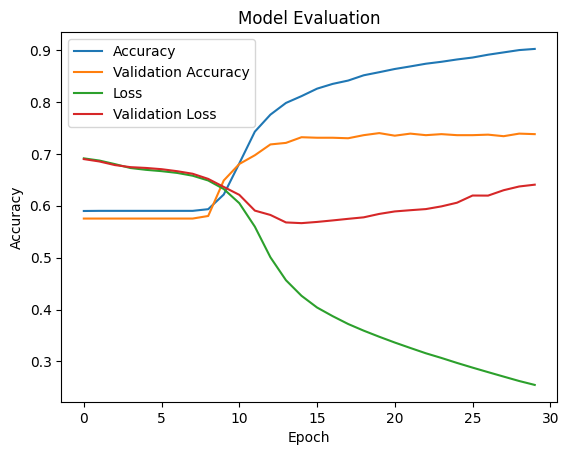

In [124]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

2

In [126]:
model_do = Sequential()

model_do.add(Embedding(num_words+1, 32, input_length=maxlen_tokens))

model_do.add(LSTM(128, return_sequences=True))
model_do.add(Dropout(0.2))

model_do.add(LSTM(128))
model_do.add(Dropout(0.2))

model_do.add(Dense(units=256, activation='relu'))

model_do.add(Dense(units=1, activation='sigmoid'))

model_do.build(input_shape=(None, maxlen_tokens))

model_do.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 32)            284384    
                                                                 
 lstm_22 (LSTM)              (None, 20, 128)           82432     
                                                                 
 dropout_2 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               33024     
                                                                 
 dense_23 (Dense)            (None, 1)               

In [127]:
opt_do = Adam(learning_rate=0.00001)

model_do.compile(optimizer=opt_do, loss='binary_crossentropy', metrics=['accuracy'])

In [129]:
hist_do = model_do.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=30)

Epoch 1/30
127/127 [==============================] - 3s 23ms/step - loss: 0.6508 - accuracy: 0.5927 - val_loss: 0.6523 - val_accuracy: 0.5853
Epoch 2/30
127/127 [==============================] - 3s 24ms/step - loss: 0.6379 - accuracy: 0.6249 - val_loss: 0.6415 - val_accuracy: 0.6151
Epoch 3/30
127/127 [==============================] - 3s 23ms/step - loss: 0.6192 - accuracy: 0.6691 - val_loss: 0.6336 - val_accuracy: 0.6657
Epoch 4/30
127/127 [==============================] - 3s 23ms/step - loss: 0.5912 - accuracy: 0.7144 - val_loss: 0.6086 - val_accuracy: 0.6994
Epoch 5/30
127/127 [==============================] - 3s 23ms/step - loss: 0.5479 - accuracy: 0.7615 - val_loss: 0.5834 - val_accuracy: 0.7073
Epoch 6/30
127/127 [==============================] - 3s 23ms/step - loss: 0.4919 - accuracy: 0.7814 - val_loss: 0.5653 - val_accuracy: 0.7183
Epoch 7/30
127/127 [==============================] - 3s 23ms/step - loss: 0.4466 - accuracy: 0.7997 - val_loss: 0.5602 - val_accuracy: 0.7212

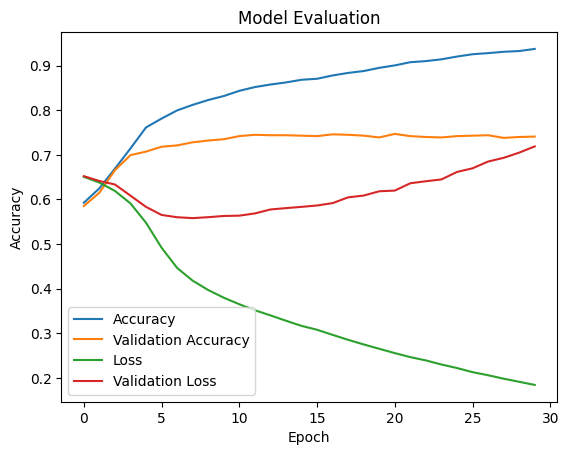

In [130]:
plt.plot(hist_do.history["accuracy"])
plt.plot(hist_do.history['val_accuracy'])
plt.plot(hist_do.history['loss'])
plt.plot(hist_do.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

In [132]:
model_final = Sequential()

model_final.add(Embedding(num_words+1, 32, input_length=maxlen_tokens))

model_final.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())

model_final.add(LSTM(128))
model.add(BatchNormalization())

model_final.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())

model_final.add(Dense(units=1, activation='sigmoid'))

model_final.build(input_shape=(None, maxlen_tokens))

model_final.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 20, 32)            284384    
                                                                 
 lstm_25 (LSTM)              (None, 20, 64)            24832     
                                                                 
 lstm_26 (LSTM)              (None, 128)               98816     
                                                                 
 dense_24 (Dense)            (None, 256)               33024     
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                                 
Total params: 441313 (1.68 MB)
Trainable params: 441313 (1.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
opt_final = Adam(learning_rate=0.00001,)

model_final.compile(optimizer=opt_final, loss='binary_crossentropy', metrics=['accuracy'])

In [134]:
hist_final = model_final.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=20)

Epoch 1/20
127/127 [==============================] - 4s 20ms/step - loss: 0.6914 - accuracy: 0.5902 - val_loss: 0.6902 - val_accuracy: 0.5754
Epoch 2/20
127/127 [==============================] - 2s 17ms/step - loss: 0.6881 - accuracy: 0.5902 - val_loss: 0.6870 - val_accuracy: 0.5754
Epoch 3/20
127/127 [==============================] - 2s 17ms/step - loss: 0.6835 - accuracy: 0.5902 - val_loss: 0.6824 - val_accuracy: 0.5754
Epoch 4/20
127/127 [==============================] - 2s 17ms/step - loss: 0.6772 - accuracy: 0.5902 - val_loss: 0.6773 - val_accuracy: 0.5754
Epoch 5/20
127/127 [==============================] - 2s 17ms/step - loss: 0.6722 - accuracy: 0.5902 - val_loss: 0.6750 - val_accuracy: 0.5754
Epoch 6/20
127/127 [==============================] - 2s 17ms/step - loss: 0.6698 - accuracy: 0.5902 - val_loss: 0.6736 - val_accuracy: 0.5754
Epoch 7/20
127/127 [==============================] - 2s 17ms/step - loss: 0.6674 - accuracy: 0.5902 - val_loss: 0.6720 - val_accuracy: 0.5754

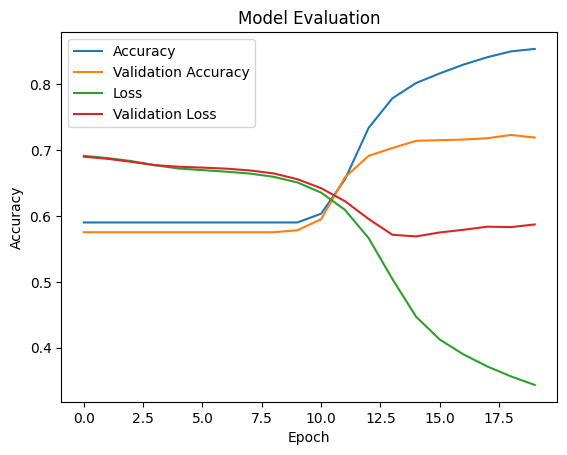

In [135]:
plt.plot(hist_final.history["accuracy"])
plt.plot(hist_final.history['val_accuracy'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()